In [1]:
!pip install transformers

In [2]:
import os
import logging
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from random import randint, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project

/content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project


In [5]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_theme()

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project/Model')

from Utils import *

In [7]:
import random
import numpy as np
import torch

def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # for CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # for reproducibility

set_seed(123)

# Training

In [8]:
data_path = "Final/en_dataset.xlsx"
train_data_path = "Final/train.xlsx"
val_data_path = "Final/val.xlsx"
test_data_path = 'Final/test.xlsx'
sheet_name = "Sheet1"

In [9]:
model_ckpt = "bert-base-uncased"
batch_size = 16

train_ds = SocialMediaDS(
    data_path=train_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_ds.collate_fn)

val_ds = SocialMediaDS(
    data_path=val_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

test_ds = SocialMediaDS(
    data_path=test_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
test_dl = DataLoader(test_ds, batch_size=batch_size, collate_fn=test_ds.collate_fn)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
print(f'Size of training data: {len(train_ds)}')
print(f'Size of validation data: {len(val_ds)}')
print(f'Size of validation data: {len(test_ds)}')

Size of training data: 1272
Size of validation data: 71
Size of validation data: 71


In [11]:
model = EmotionClassifier(model_ckpt, emotion_nlabels=7).to(device)
model.unfreeze_encoder()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [12]:
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [13]:
mem = train_and_validate(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    model_save_path="Model/saved_models/model_masked.pth",
    epochs=5
)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 2.329	Acc: 0.309	F1: 0.313
Val Loss:   1.446	Acc:   0.543	F1:   0.554

New best F1: 0.554 - Model saved!
Epoch 2/5
Train Loss: 1.416	Acc: 0.557	F1: 0.566
Val Loss:   1.803	Acc:   0.470	F1:   0.490

Epoch 3/5
Train Loss: 0.935	Acc: 0.697	F1: 0.708
Val Loss:   1.412	Acc:   0.573	F1:   0.560

New best F1: 0.560 - Model saved!
Epoch 4/5
Train Loss: 0.665	Acc: 0.780	F1: 0.787
Val Loss:   1.706	Acc:   0.552	F1:   0.574

New best F1: 0.574 - Model saved!
Epoch 5/5
Train Loss: 0.562	Acc: 0.833	F1: 0.845
Val Loss:   1.775	Acc:   0.552	F1:   0.548

Training completed!


# Evaluation

In [14]:
emo_preds, emo_targets, all_texts = evaluate_model(model, test_ds, test_dl)

  0%|          | 0/5 [00:00<?, ?it/s]

                precision    recall  f1-score   support
0                   62.50     50.00     55.56        10
1                   62.50     62.50     62.50         8
2                   53.85     70.00     60.87        10
3                   78.57    100.00     88.00        11
4                   60.00     54.55     57.14        11
5                   60.00     30.00     40.00        10
6                   61.54     72.73     66.67        11

accuracy                                63.38        71
macro avg           62.71     62.82     61.53        71
weighted avg        62.88     63.38     61.89        71


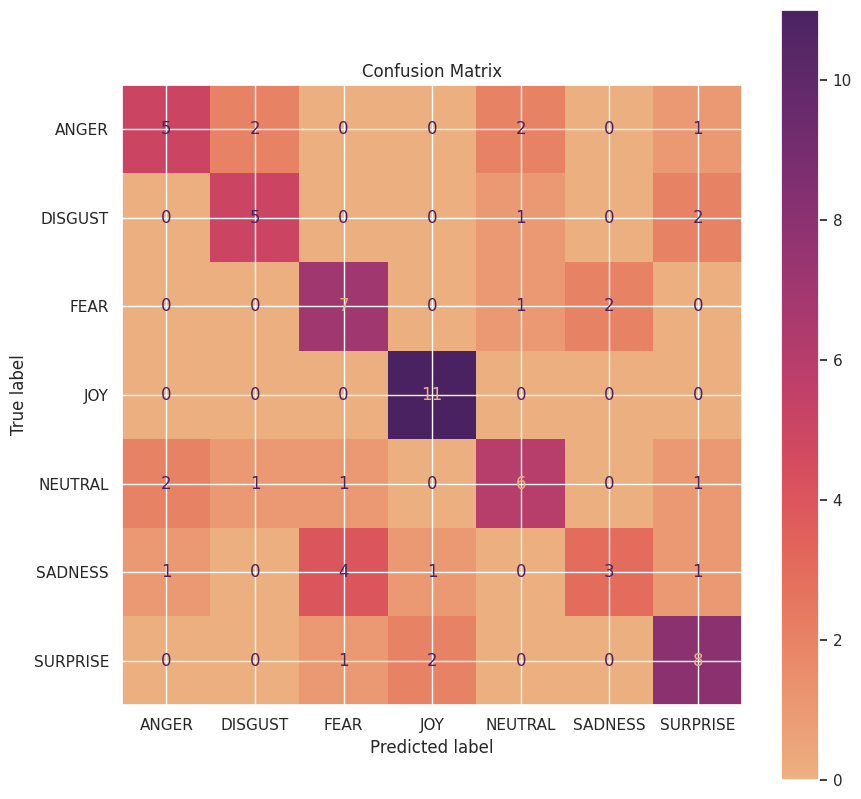

In [16]:
plot_confusion_matrix(emo_preds, emo_targets)